In [3]:
import numpy as np
from functions import *
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# M/M/1 Básica e Variantes (20 pontos)

## Cenário 1:  $λ= 1, μ= 2, ρ= 0.5$

In [4]:
result = simulador(lambda_=1, mi_=2, tempo_total_simulacao=10000, deterministico=False)

In [5]:
# Index
indices = ['Tempo médio do cliente no sistema (L)',
           'Tempo médio de cliente na fila (Lq)',
           'Número médio de clientes no sistema (W)',
           'Número médio de clientes na fila (Wq)',
           'Probabilidade do sistema ocupado (p)']

# Valor Simulado
data_simulado = [
        result['L'],
        result['Lq'],
        result['W'],
        result['Wq'],
        result['rho']]

def custom_round(value):
    return round(value, 2)
data_simulado = [custom_round(value) for value in data_simulado]

# Valor Analitico
data_analitico = valor_analitico(1,2)

df = pd.DataFrame({'Simulado': data_simulado, 'Analítico': data_analitico}, index=indices)
df

,Simulado,Analítico
Tempo médio do cliente no sistema (L),1.02,1.0
Tempo médio de cliente na fila (Lq),0.51,0.5
Número médio de clientes no sistema (W),1.00,1.0
Número médio de clientes na fila (Wq),0.50,1.0
Probabilidade do sistema ocupado (p),0.51,0.5


### CDF Número de clientes no sistema

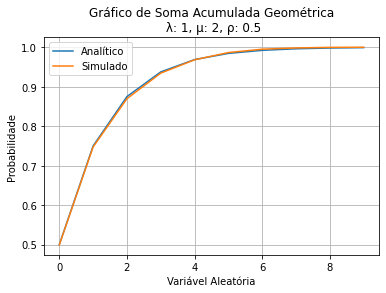

In [6]:
# Valores Simulador
pi = result['pi']
cumulative_sum = np.cumsum(list(pi.values()))

# Valores Analíticos
p = 0.5
x = np.arange(0, len(pi))
y = np.cumsum(geo(p, x))

# Plotagem
plt.plot(x, y, label='Analítico')
plt.plot(result['pi'].keys(), cumulative_sum, label='Simulado')
# plt.fill_between(x, y, cumulative_sum - 5.1, cumulative_sum + 5.1, color='gray', alpha=0.2, label='Intervalo de Confiança (95%)')
plt.xlabel('Variável Aleatória')
plt.ylabel('Probabilidade')
plt.legend()
plt.title(f'Gráfico de Soma Acumulada Geométrica\n λ: {1}, μ: {2}, ρ: {0.5}')
plt.grid(True)
plt.show()


### CDF Tempo de espera dos clientes no sistema (fila de espera + servidor)

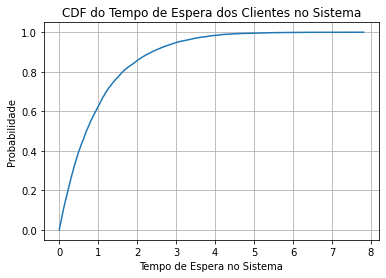

In [7]:
result['Tempo Espera Sistema'].sort()
probabilidade_acumulada = np.arange(1, len(result['Tempo Espera Sistema']) + 1) / len(result['Tempo Espera Sistema'])

plt.plot(result['Tempo Espera Sistema'], probabilidade_acumulada)
plt.xlabel('Tempo de Espera no Sistema')
plt.ylabel('Probabilidade')
plt.title('CDF do Tempo de Espera dos Clientes no Sistema')
plt.grid(True)
plt.show()

### Visualizações e Intervalo de Confiança

Vamos verificar o intervalo de confiança para o tempo médio do cliente no sistema.

In [10]:
data_ic = simulator_confidence_interval(lambda_= 1, mi_= 2, sample_size = 1000, conf_level = 0.95)

In [9]:
for key, value in data_ic['pi']['IC'].items():
    if not value:
        data_ic['pi']['IC'][key] = (np.nan, np.nan)

df = pd.DataFrame(data_ic['pi']['IC']).T
df.columns = ['Limite Inferior', 'Limite Superior']
df = df.dropna(how='all')
df

,Limite Inferior,Limite Superior
0,0.499064,0.502472
1,0.248776,0.250436
2,0.123977,0.125432
3,0.061583,0.062874
4,0.030863,0.031865
5,0.015357,0.016114
6,0.007595,0.008150
7,0.004295,0.004678
8,0.002890,0.003178
9,0.002377,0.002601


### Dados Antigos

In [88]:
fig = ff.create_distplot([data_ic['Lq']['Amostras']], ['Lq'], curve_type='normal', bin_size=0.006)
fig.show()

In [89]:
fig = px.histogram(data_ic['Lq']['Amostras'], marginal="box")
fig.show()

### Remoção de  outliers

In [92]:
data_without_outliers = remove_outliers(data_ic['Lq']['Amostras'])
fig = ff.create_distplot([data_without_outliers], ['Lq'], curve_type='normal', bin_size=0.006)
fig.show()

Porcentagem de outliers removidos: 1.5 %


## Cenário 2:  $λ= 2, μ= 4, ρ= 0.5$

In [11]:
result = simulador(lambda_=2, mi_=4, tempo_total_simulacao=10000, deterministico=False)

In [12]:
# Index
indices = ['Tempo médio do cliente no sistema (L)',
           'Tempo médio de cliente na fila (Lq)',
           'Número médio de clientes no sistema (W)',
           'Número médio de clientes na fila (Wq)',
           'Probabilidade do sistema ocupado (p)']

# Valor Simulado
data_simulado = [
        result['L'],
        result['Lq'],
        result['W'],
        result['Wq'],
        result['rho']]

def custom_round(value):
    return round(value, 2)
data_simulado = [custom_round(value) for value in data_simulado]

# Valor Analitico
data_analitico = valor_analitico(1,2)

df = pd.DataFrame({'Simulado': data_simulado, 'Analítico': data_analitico}, index=indices)
df

,Simulado,Analítico
Tempo médio do cliente no sistema (L),1.04,1.0
Tempo médio de cliente na fila (Lq),0.53,0.5
Número médio de clientes no sistema (W),0.51,1.0
Número médio de clientes na fila (Wq),0.26,1.0
Probabilidade do sistema ocupado (p),0.51,0.5


### CDF Número de clientes no sistema

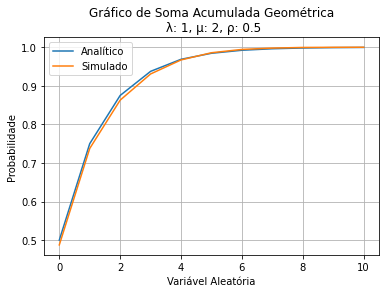

In [15]:
# Valores Simulador
pi = result['pi']
cumulative_sum = np.cumsum(list(pi.values()))

# Valores Analíticos
p = 0.5
x = np.arange(0, len(pi))
y = np.cumsum(geo(p, x))

# Plotagem
plt.plot(x, y, label='Analítico')
plt.plot(result['pi'].keys(), cumulative_sum, label='Simulado')
# plt.fill_between(x, y, cumulative_sum - 5.1, cumulative_sum + 5.1, color='gray', alpha=0.2, label='Intervalo de Confiança (95%)')
plt.xlabel('Variável Aleatória')
plt.ylabel('Probabilidade')
plt.legend()
plt.title(f'Gráfico de Soma Acumulada Geométrica\n λ: {1}, μ: {2}, ρ: {0.5}')
plt.grid(True)
plt.show()


### CDF Tempo de espera dos clientes no sistema (fila de espera + servidor)

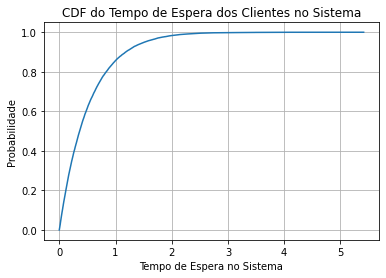

In [16]:
result['Tempo Espera Sistema'].sort()
probabilidade_acumulada = np.arange(1, len(result['Tempo Espera Sistema']) + 1) / len(result['Tempo Espera Sistema'])

plt.plot(result['Tempo Espera Sistema'], probabilidade_acumulada)
plt.xlabel('Tempo de Espera no Sistema')
plt.ylabel('Probabilidade')
plt.title('CDF do Tempo de Espera dos Clientes no Sistema')
plt.grid(True)
plt.show()

### Visualizações e Intervalo de Confiança

Vamos verificar o intervalo de confiança para o tempo médio do cliente no sistema.

In [17]:
data_ic = simulator_confidence_interval(lambda_= 1, mi_= 2, sample_size = 1000, conf_level = 0.95)

In [18]:
for key, value in data_ic['pi']['IC'].items():
    if not value:
        data_ic['pi']['IC'][key] = (np.nan, np.nan)

df = pd.DataFrame(data_ic['pi']['IC']).T
df.columns = ['Limite Inferior', 'Limite Superior']
df = df.dropna(how='all')
df

,Limite Inferior,Limite Superior
0,0.499629,0.503088
1,0.249825,0.251477
2,0.124044,0.125539
3,0.061515,0.062863
4,0.030000,0.030993
5,0.014725,0.015484
6,0.007494,0.008044
7,0.004226,0.004615
8,0.002988,0.003272
9,0.002364,0.002591


### Dados Antigos

In [19]:
fig = ff.create_distplot([data_ic['Lq']['Amostras']], ['Lq'], curve_type='normal', bin_size=0.006)
fig.show()

In [20]:
fig = px.histogram(data_ic['Lq']['Amostras'], marginal="box")
fig.show()

### Remoção de  outliers

In [21]:
data_without_outliers = remove_outliers(data_ic['Lq']['Amostras'])
fig = ff.create_distplot([data_without_outliers], ['Lq'], curve_type='normal', bin_size=0.006)
fig.show()

Porcentagem de outliers removidos: 1.6 %


## Cenário 3:  $λ= 4, μ= 2, ρ= 2$

In [22]:
result = simulador(lambda_=4, mi_=2, tempo_total_simulacao=10000, deterministico=False)

In [27]:
# Index
indices = ['Tempo médio do cliente no sistema (L)',
           'Tempo médio de cliente na fila (Lq)',
           'Número médio de clientes no sistema (W)',
           'Número médio de clientes na fila (Wq)',
           'Probabilidade do sistema ocupado (p)']

# Valor Simulado
data_simulado = [
        result['L'],
        result['Lq'],
        result['W'],
        result['Wq'],
        result['rho']]

def custom_round(value):
    return round(value, 2)
data_simulado = [custom_round(value) for value in data_simulado]

# Valor Analitico
data_analitico = valor_analitico(1,2)

df = pd.DataFrame({'Simulado': data_simulado, 'Analítico': data_analitico}, index=indices)
df

,Simulado,Analítico
Tempo médio do cliente no sistema (L),10053.51,1.0
Tempo médio de cliente na fila (Lq),10052.51,0.5
Número médio de clientes no sistema (W),2506.70,1.0
Número médio de clientes na fila (Wq),2506.45,1.0
Probabilidade do sistema ocupado (p),1.00,0.5


### CDF Número de clientes no sistema

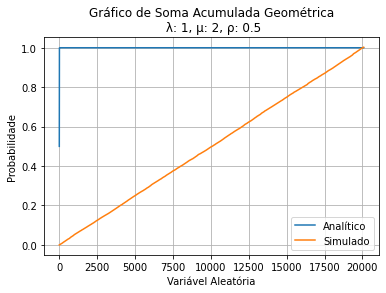

In [28]:
# Valores Simulador
pi = result['pi']
cumulative_sum = np.cumsum(list(pi.values()))

# Valores Analíticos
p = 0.5
x = np.arange(0, len(pi))
y = np.cumsum(geo(p, x))

# Plotagem
plt.plot(x, y, label='Analítico')
plt.plot(result['pi'].keys(), cumulative_sum, label='Simulado')
# plt.fill_between(x, y, cumulative_sum - 5.1, cumulative_sum + 5.1, color='gray', alpha=0.2, label='Intervalo de Confiança (95%)')
plt.xlabel('Variável Aleatória')
plt.ylabel('Probabilidade')
plt.legend()
plt.title(f'Gráfico de Soma Acumulada Geométrica\n λ: {1}, μ: {2}, ρ: {0.5}')
plt.grid(True)
plt.show()


### CDF Tempo de espera dos clientes no sistema (fila de espera + servidor)

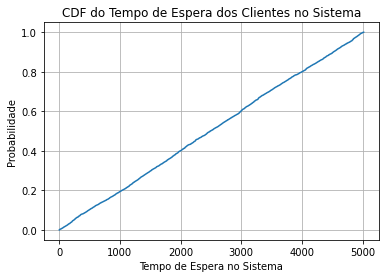

In [29]:
result['Tempo Espera Sistema'].sort()
probabilidade_acumulada = np.arange(1, len(result['Tempo Espera Sistema']) + 1) / len(result['Tempo Espera Sistema'])

plt.plot(result['Tempo Espera Sistema'], probabilidade_acumulada)
plt.xlabel('Tempo de Espera no Sistema')
plt.ylabel('Probabilidade')
plt.title('CDF do Tempo de Espera dos Clientes no Sistema')
plt.grid(True)
plt.show()

### Visualizações e Intervalo de Confiança

Vamos verificar o intervalo de confiança para o tempo médio do cliente no sistema.

In [ ]:
data_ic = simulator_confidence_interval(lambda_= 1, mi_= 2, sample_size = 1000, conf_level = 0.95)

In [ ]:
for key, value in data_ic['pi']['IC'].items():
    if not value:
        data_ic['pi']['IC'][key] = (np.nan, np.nan)

df = pd.DataFrame(data_ic['pi']['IC']).T
df.columns = ['Limite Inferior', 'Limite Superior']
df = df.dropna(how='all')
df

,Limite Inferior,Limite Superior
0,0.499064,0.502472
1,0.248776,0.250436
2,0.123977,0.125432
3,0.061583,0.062874
4,0.030863,0.031865
5,0.015357,0.016114
6,0.007595,0.008150
7,0.004295,0.004678
8,0.002890,0.003178
9,0.002377,0.002601


### Dados Antigos

In [ ]:
fig = ff.create_distplot([data_ic['Lq']['Amostras']], ['Lq'], curve_type='normal', bin_size=0.006)
fig.show()

In [ ]:
fig = px.histogram(data_ic['Lq']['Amostras'], marginal="box")
fig.show()

### Remoção de  outliers

In [ ]:
data_without_outliers = remove_outliers(data_ic['Lq']['Amostras'])
fig = ff.create_distplot([data_without_outliers], ['Lq'], curve_type='normal', bin_size=0.006)
fig.show()

Porcentagem de outliers removidos: 1.5 %
